# DoomTakeCover-v0

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from controller import make_controller
from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/ddl05_doom.config'])

In [2]:
import matplotlib.pyplot as plt
import matplotlib.animation
plt.style.use('seaborn')
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [4]:
filelist = os.listdir(DATA_DIR)

In [5]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [6]:
obs.shape

(215, 64, 64, 3)

In [7]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [8]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

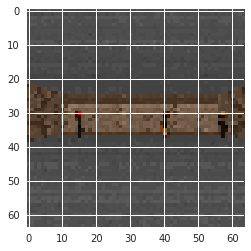

In [9]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [10]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.1476 -0.7545  1.7876  0.5656 -0.8764 -0.2414  0.812   0.6949  0.0155 -0.6218 -0.8329  0.1449
  1.1675 -0.1415  0.5351  1.4906  0.1845 -0.0577  0.3061 -0.3486  1.4521 -2.3572  1.8422 -2.1186
  0.9701 -0.0271  0.3329  0.08   -0.7798 -0.8465  0.1643  1.7835 -1.1357  0.8892 -0.9718 -1.4803
  0.7359 -0.2629 -0.0419  0.2038  0.0138  0.5675  1.4546  2.9161  0.3967  0.9526  1.2278  0.6142
  0.3182 -0.6822 -0.6254 -0.3907 -0.8859  1.5035  0.0473  0.3268 -0.6355 -0.415   0.2817 -2.5894
  1.0462  0.3823 -1.3864  2.7629], shape=(64,), dtype=float32)


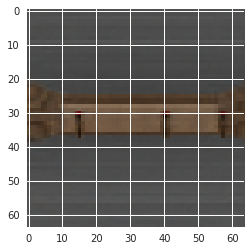

In [11]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

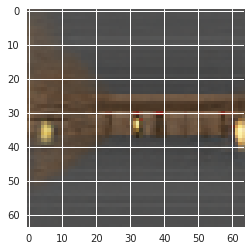

In [12]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

# Simulate and Store for Animation

In [13]:
def sim(c, env, vae, is_true_env=False, z_size=64, max_ep_len=1000):
    o = env.reset()
    r_list = []
    total_r_list = []
    true_frames = []
    if is_true_env:
        o, frame = o
        true_frames.append(tf.squeeze(frame))
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    else:
        z = np.expand_dims(o[:z_size], axis=0)
        reconstruct = vae.decode(z)
    decoded_frames = [tf.squeeze(reconstruct)]
    
    for _ in range(max_ep_len): # episode length is a thousand
        a = c.get_action(o)
        o, r, d, _ = env.step(a)
        r_list.append(r)
        total_r_list.append(sum(r_list))
        if is_true_env:
            env.render('rgb_array')
            o, frame = o
            true_frames.append(tf.squeeze(frame))
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        else:
            z = np.expand_dims(o[:z_size], axis=0)
            reconstruct = vae.decode(z)
        decoded_frames.append(tf.squeeze(reconstruct))
        
        if d:
            break
    return decoded_frames, true_frames, r_list, total_r_list

## Acting in dream environment
visualize what the agent sees when acting in the dream environment

In [ ]:
c = make_controller(args)
c.load_model('results/{}/{}/eval_input0.1_hidden0.1_log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=True, with_obs=True)
reconstruct_episode, _, dream_r, dream_total_r = sim(c, true_env, vae, is_true_env=False, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

In [ ]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(reconstruct_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, dream_r[frame_index+1], dream_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(reconstruct_episode), blit=True)


## Acting in true environment
visualize what the agent sees when acting in the true environment

In [ ]:
c = make_controller(args)
c.load_model('results/{}/{}/eval_input0.1_hidden0.1_log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

In [ ]:
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(true_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Table for Controller

In [21]:
def dream_ret_std(log_path, idx):
    with open(log_path, 'r') as f:
        data = json.load(f)
    data = np.array(data)
    ret = data[idx, 1]
    std = data[idx, 2]
    return ret, std

def real_ret_std(log_path):
    with open(log_path, 'r') as f:
      data = json.load(f)
    data = np.array(data)

    ret = data[-1, 1]
    std = data[-1, 2]
    idx = data[-1, 0]
    return ret, std, int(idx)

In [22]:
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/ddl05_doom.config'])

env_name = 'DoomTakeCover-v0'
dropout_rates = ['0.0', '0.05', '0.1', '0.2', '0.3', '0.5']
dream_file_list = []
real_file_list = []
for p_i in dropout_rates:
    dream_path = 'results/FullDropout05_WorldModels/{}/eval_input{}_hidden{}_log/{}.cma.16.64.eval_hist.json'.format(env_name, p_i, p_i, env_name)
    real_path = 'results/FullDropout05_WorldModels/{}/eval_input{}_hidden{}_log/{}.cma.16.64.real_eval_hist.json'.format(env_name, p_i, p_i, env_name)
    dream_file_list.append(dream_path)
    real_file_list.append(real_path)

eval_rets = []
eval_stds = []

with open('doom_eval_results.json') as f:
    real_rets_dict = json.load(f)

for p_i, dream_path, real_path in zip(dropout_rates, dream_file_list, real_file_list):
    _, _, idx = real_ret_std(real_path)
    real_ret, real_std = real_rets_dict[p_i]
    dream_ret, dream_std = dream_ret_std(log_path=dream_path, idx=idx//args.controller_eval_steps)
    print('step: {}, dropout_rate: {}%, dream ret: {:.0f}, dream std: {:.0f}, eval ret: {:.0f}, eval std: {:.0f}'.format(idx, p_i, dream_ret, dream_std, real_ret, real_std,))
    eval_rets.append(real_ret)
    eval_stds.append(real_std)

step: 1325, dropout_rate: 0.0%, dream ret: 1844, dream std: 488, eval ret: 767, eval std: 445
step: 1975, dropout_rate: 0.05%, dream ret: 1570, dream std: 631, eval ret: 868, eval std: 508
step: 1475, dropout_rate: 0.1%, dream ret: 1221, dream std: 664, eval ret: 933, eval std: 552
step: 1650, dropout_rate: 0.2%, dream ret: 468, dream std: 313, eval ret: 867, eval std: 506
step: 1750, dropout_rate: 0.3%, dream ret: 195, dream std: 113, eval ret: 802, eval std: 487
step: 650, dropout_rate: 0.5%, dream ret: 134, dream std: 69, eval ret: 205, eval std: 43


Text(0.5, 0, 'Inference Dropout Rate')

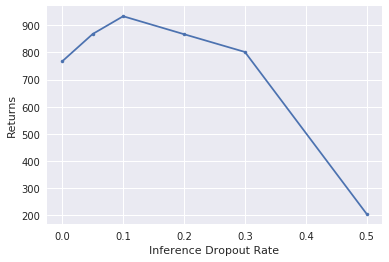

In [23]:
%matplotlib inline
plt.figure()
plt.plot([float(p_i) for p_i in dropout_rates], eval_rets, '.-')
#plt.title('DoomTakeCover-v0')
plt.ylabel('Returns')
plt.xlabel('Inference Dropout Rate')


In [24]:
def add_to_plot(x, y, std=None):
    plt.plot(x, y, '.-')
    if std is not None:
        plt.fill_between(x, y-std, y+std, alpha=0.2)

# CarRacing-v0

In [28]:
import numpy as np
import os
import json
import tensorflow as tf
import random
from vae.vae import CVAE
from rnn.rnn import MDNRNN
# from controller import make_controller
# from env import make_env
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/ddl05_carracing_fixed_n.config'])

In [29]:
import matplotlib.pyplot as plt
import matplotlib.animation
%matplotlib inline
np.set_printoptions(precision=4, edgeitems=6, linewidth=100, suppress=True)

In [30]:
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # disable GPU

DATA_DIR = "results/{}/{}/record".format(args.exp_name, args.env_name)
model_path_name = "results/{}/{}/tf_vae".format(args.exp_name, args.env_name)

In [31]:
filelist = os.listdir(DATA_DIR)

In [32]:
obs = np.load(os.path.join(DATA_DIR, random.choice(filelist)))["obs"]
obs = obs.astype(np.float32)/255.0

In [33]:
obs.shape

(1000, 64, 64, 3)

In [34]:
frame = random.choice(obs).reshape(1, 64, 64, 3)

In [35]:
vae = CVAE(args)

vae.set_weights(tf.keras.models.load_model(model_path_name, compile=False).get_weights())

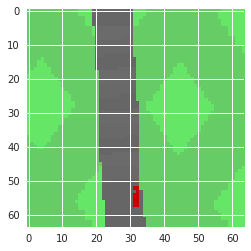

In [36]:
%matplotlib inline
# show recorded frame that will be fed into the input of VAE
plt.imshow(frame[0])
plt.show()

In [37]:
batch_z = vae.encode(frame)
print(batch_z[0]) # print out sampled z
reconstruct = vae.decode(batch_z)

tf.Tensor(
[-0.9307 -0.5997 -0.8742 -1.0149  0.389   0.3989 -0.0397 -0.1088  0.5033  0.8018  0.3465  0.6044
  0.7343 -0.9334 -0.1721 -0.6444 -1.1368 -0.643  -0.1711 -1.7123 -0.3683  0.707  -1.0631  0.7673
  1.1531 -0.478   0.5255  0.0245  1.4394  0.087  -1.9205  1.1428], shape=(32,), dtype=float32)


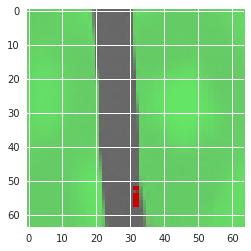

In [38]:
%matplotlib inline
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Dream Samples

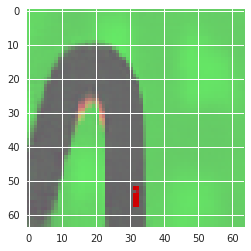

In [39]:
%matplotlib inline
batch_z = tf.random.normal((1, args.z_size)).numpy()
reconstruct = vae.decode(batch_z)
# show reconstruction
plt.imshow(reconstruct[0])
plt.show()

## Driving in true environment
visualize what the agent sees when driving in the true environment

In [ ]:
c = make_controller(args)
c.load_model('results/{}/{}/eval_input0.1_hidden0.1_log/{}.cma.16.64.json'.format(args.exp_name, args.env_name, args.env_name))
true_env = make_env(args, dream_env=False, with_obs=True)
reconstruct_episode, true_episode, true_r, true_total_r = sim(c, true_env, vae, is_true_env=True, z_size=args.z_size, max_ep_len=args.max_frames)
true_env.close()

In [ ]:
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
%matplotlib notebook
# stupid jupyter bug, just keep copy pasting until it works

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation

f = plt.figure()
ax = f.gca()

image = plt.imshow(true_episode[0].numpy(), interpolation='None', animated=True)

def function_for_animation(frame_index):
    image.set_data(reconstruct_episode[frame_index+1].numpy())
    ax.set_title('frame: {}, r: {:.2f}, total reward: {:.2f}'.format(frame_index, true_r[frame_index+1], true_total_r[frame_index+1]))
    return image,

ani = matplotlib.animation.FuncAnimation(f, function_for_animation, interval=40, frames=len(true_episode), blit=True)


## Return Plot for Controller

In [42]:
env_name = 'CarRacingFixedN-v0'
from utils import PARSER
args = PARSER.parse_args(['--config_path', 'configs/ddl05_carracing_fixed_n.config'])

dropout_rates = ['0.0', '0.05', '0.1', '0.2', '0.3', '0.5']
dream_file_list = []
real_file_list = []
for p_i in dropout_rates:
    dream_path = 'results/semi_FullDropout05_WorldModels/{}/eval_input{}_hidden{}_log/{}.cma.16.64.eval_hist.json'.format(env_name, p_i, p_i, env_name)
    real_path = 'results/semi_FullDropout05_WorldModels/{}/eval_input{}_hidden{}_log/{}.cma.16.64.real_eval_hist.json'.format(env_name, p_i, p_i, env_name)
    dream_file_list.append(dream_path)
    real_file_list.append(real_path)

eval_rets = []
eval_stds = []
for p_i, dream_path, real_path in zip(dropout_rates, dream_file_list, real_file_list):
    real_ret, real_std, idx = real_ret_std(real_path)
    dream_ret, dream_std = dream_ret_std(log_path=dream_path, idx=idx//args.controller_eval_steps)
    print('step: {}, dropout_rate: {}%, dream ret: {:.0f}, dream std: {:.0f}, eval ret: {:.0f}, eval std: {:.0f}'.format(idx, p_i, dream_ret, dream_std, real_ret, real_std,))
    eval_rets.append(real_ret)
    eval_stds.append(real_std)

step: 675, dropout_rate: 0.0%, dream ret: 1585, dream std: 268, eval ret: -36, eval std: 19
step: 1950, dropout_rate: 0.05%, dream ret: 990, dream std: 253, eval ret: 247, eval std: 258
step: 1825, dropout_rate: 0.1%, dream ret: 881, dream std: 214, eval ret: 625, eval std: 289
step: 1900, dropout_rate: 0.2%, dream ret: 447, dream std: 204, eval ret: 589, eval std: 165
step: 1950, dropout_rate: 0.3%, dream ret: 204, dream std: 137, eval ret: 253, eval std: 156
step: 1950, dropout_rate: 0.5%, dream ret: 84, dream std: 92, eval ret: -48, eval std: 20


Text(0.5, 0, 'Inference Dropout Rate')

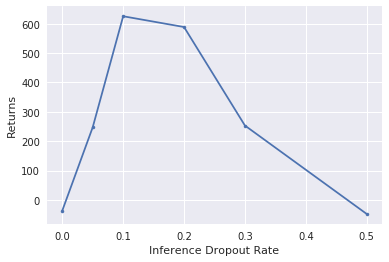

In [43]:
%matplotlib inline
plt.figure()
plt.plot([float(p_i) for p_i in dropout_rates], eval_rets, '.-')
#plt.title('CarRacingFixedN-v0')
plt.ylabel('Returns')
plt.xlabel('Inference Dropout Rate')


# Evaluate M

In [44]:
import numpy as np
from rnn.rnn import sample_vae, MDNRNN

def load_data(npz_loc):
  raw_data = np.load(npz_loc)
  # load preprocessed data
  mu = raw_data["mu"]
  logvar = raw_data["logvar"]
  action =  raw_data["action"]
  r = raw_data["reward"]
  d = raw_data["done"]
  N_tiles = raw_data["N"]
  return mu, logvar, action, r, d, N_tiles

def eval_m(sm_loc, series_loc, args, p=0.0):
    # prepare test data
    test_mu, test_logvar, test_action, test_r, test_d, _ = load_data(series_loc)
    test_z = tf.cast(sample_vae(test_mu, test_logvar), dtype=tf.float32)
    test_action = tf.cast(test_action, dtype=tf.float32)
    test_inputs = tf.concat([test_z, test_action], axis=2)
    dummy_zero = tf.zeros([test_z.shape[0], 1, test_z.shape[2]], dtype=tf.float32)
    test_z_targ = tf.concat([test_z[:, 1:, :], dummy_zero], axis=1) # zero pad the end but we don't actually use it
    test_z_mask = 1.0 - test_d
    test_z_targ = tf.concat([test_z_targ, test_z_mask], axis=2) # use a signal to not pass grad

    test_outputs = {'MDN': test_z_targ}
    if args.rnn_r_pred == 1:
        test_r_mask = tf.concat([tf.ones([test_d.shape[0], 1, 1], dtype=tf.float32), 1.0 - test_d[:, :-1, :]], axis=1)
        test_r_targ = tf.concat([test_r, test_r_mask], axis=2)
        test_outputs['r'] = test_r_targ
    if args.rnn_d_pred == 1:
        test_d_mask = tf.concat([tf.ones([test_d.shape[0], 1, 1], dtype=tf.float32), 1.0 - test_d[:, :-1, :]], axis=1)
        test_d_targ = tf.concat([test_d, test_d_mask], axis=2)
        test_outputs['d'] = test_d_targ

    args.rnn_input_dropout = p
    args.rnn_hidden_dropout = p
    rnn = MDNRNN(args=args)
    rnn.set_weights([param_i.numpy() for param_i in tf.saved_model.load(sm_loc).variables])
    rnn.compile(optimizer=rnn.optimizer, loss=rnn.get_loss())
    
    loss = {}
    outs = rnn(test_inputs, training=True) #apply mask
    loss_fns = rnn.get_loss()
    for loss_fn_name, loss_fn in loss_fns.items():
        y_true = test_outputs[loss_fn_name]
        y_pred = outs[loss_fn_name]
        loss[loss_fn_name] = loss_fn(y_true=y_true, y_pred=y_pred).numpy()
    return loss

# CarRacingFixedN-v0 Model Loss

In [45]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

args = PARSER.parse_args(['--config_path', 'configs/ddl05_carracing_fixed_n.config'])
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
car_loss_totals = []
for p_i in dropout_rates:
    car_rnn_loss_dict = eval_m(sm_loc='results/semi_FullDropout05_WorldModels/CarRacingFixedN-v0/tf_rnn', series_loc='{}_test_traj.npz'.format(args.env_name), args=args, p=p_i)
    car_loss_totals.append(sum(car_rnn_loss_dict.values()))
    print(p_i, car_loss_totals[-1], car_rnn_loss_dict)

0.0 3.4933252597693354 {'r': 2.646686, 'MDN': 0.843907, 'd': 0.002732184}
0.1 4.0703862784430385 {'r': 3.1097806, 'MDN': 0.9542618, 'd': 0.0063439487}
0.2 4.646887764334679 {'r': 3.2829459, 'MDN': 1.3546457, 'd': 0.009296164}
0.3 5.60914340429008 {'r': 3.8999703, 'MDN': 1.6892693, 'd': 0.019903807}
0.4 10.982074663043022 {'r': 8.807918, 'MDN': 2.026502, 'd': 0.14765517}
0.5 36.90294647216797 {'r': 33.637352, 'MDN': 2.4545374, 'd': 0.8110571}


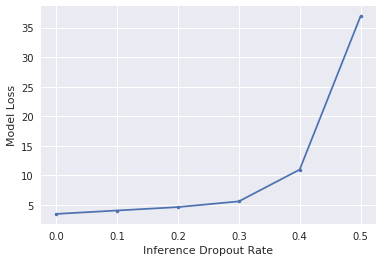

In [46]:
%matplotlib inline
plt.figure()
add_to_plot(dropout_rates, car_loss_totals)
#plt.title('CarRacingFixedN-v0')
plt.ylabel('Model Loss')
plt.xlabel('Inference Dropout Rate')
plt.show()

## Dropout vs No Dropout RNN Loss

In [47]:
args = PARSER.parse_args(['--config_path', 'configs/ddl05_carracing_fixed_n.config'])


tf.random.set_seed(1)
wm_rnn_car_loss_dict = eval_m(sm_loc='results/semi_WorldModels/CarRacingFixedN-v0/tf_rnn', series_loc='{}_test_traj.npz'.format(args.env_name), args=args, p=0.0)
wm_rnn_car_loss = sum(wm_rnn_car_loss_dict.values())

tf.random.set_seed(1)
dropout_rnn_car_loss_dict = eval_m(sm_loc='results/semi_FullDropout05_WorldModels/CarRacingFixedN-v0/tf_rnn', series_loc='{}_test_traj.npz'.format(args.env_name), args=args, p=0.0)
dropout_rnn_car_loss = sum(dropout_rnn_car_loss_dict.values())
print('No Dropout RNN CarRacing Test Loss', wm_rnn_car_loss, wm_rnn_car_loss_dict)
print('Dropout RNN CarRacing Test Loss', dropout_rnn_car_loss, dropout_rnn_car_loss_dict)



No Dropout RNN CarRacing Test Loss 3.248858162900433 {'r': 2.4578702, 'MDN': 0.78778833, 'd': 0.0031995864}
Dropout RNN CarRacing Test Loss 3.4933252597693354 {'r': 2.646686, 'MDN': 0.843907, 'd': 0.002732184}


# DoomTakeCover-v0 Model Loss

In [48]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

args = PARSER.parse_args(['--config_path', 'configs/ddl05_doom.config'])
dropout_rates = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
doom_loss_totals = []
for p_i in dropout_rates:
    doom_rnn_loss_dict = eval_m(sm_loc='results/FullDropout05_WorldModels/DoomTakeCover-v0/tf_rnn', series_loc='DoomTakeCover-v0_test_traj.npz', args=args, p=p_i)
    doom_loss_totals.append(sum(doom_rnn_loss_dict.values()))
    print(p_i, doom_loss_totals[-1], doom_rnn_loss_dict)

0.0 0.9157670699059963 {'MDN': 0.8927887, 'd': 0.022978362}
0.1 1.007385615259409 {'MDN': 0.9760983, 'd': 0.031287316}
0.2 1.1895225793123245 {'MDN': 1.1209395, 'd': 0.068583086}
0.3 1.359317235648632 {'MDN': 1.2708306, 'd': 0.088486604}
0.4 1.5165748223662376 {'MDN': 1.4036123, 'd': 0.11296257}
0.5 1.8012796938419342 {'MDN': 1.5583106, 'd': 0.24296907}


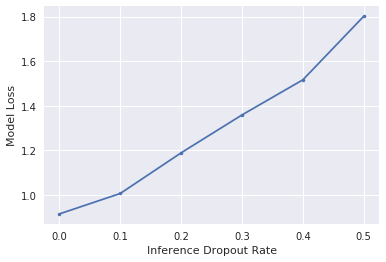

In [50]:
%matplotlib inline
plt.figure()
add_to_plot(dropout_rates, doom_loss_totals)
#plt.title('DoomTakeCover-v0')
plt.ylabel('Model Loss')
plt.xlabel('Inference Dropout Rate')
plt.show()

In [49]:
args = PARSER.parse_args(['--config_path', 'configs/ddl05_doom.config'])

tf.random.set_seed(1)
wm_rnn_doom_loss_dict = eval_m(sm_loc='results/WorldModels/DoomTakeCover-v0/tf_rnn', series_loc='{}_test_traj.npz'.format(args.env_name), args=args, p=0.0)
wm_rnn_doom_loss = sum(wm_rnn_doom_loss_dict.values())

tf.random.set_seed(1)
dropout_rnn_doom_loss_dict = eval_m(sm_loc='results/FullDropout05_WorldModels/DoomTakeCover-v0/tf_rnn', series_loc='{}_test_traj.npz'.format(args.env_name), args=args, p=0.0)
dropout_rnn_doom_loss = sum(dropout_rnn_doom_loss_dict.values())
print('No Dropout RNN DoomTakeCover-v0 Test Loss', wm_rnn_doom_loss, wm_rnn_doom_loss_dict)
print('Dropout RNN DoomTakeCover-v0 Test Loss', dropout_rnn_doom_loss, dropout_rnn_doom_loss_dict)

No Dropout RNN DoomTakeCover-v0 Test Loss 0.9124034494161606 {'MDN': 0.883134, 'd': 0.029269442}
Dropout RNN DoomTakeCover-v0 Test Loss 0.9157670699059963 {'MDN': 0.8927887, 'd': 0.022978362}
